In [278]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
import numpy as np
import time
import os
import matplotlib.pyplot as plt  

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchviz import make_dot
from utils import one_hot_encode, one_hot_decode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from utils import load_gfp_data, count_substring_mismatch, get_mutation

In [279]:
class VAE(nn.Module):
    # change architecture later to make it deeper if it's not good enough to capture all data
    def __init__(self, input_size, hidden_size, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        
    def encode(self, x):
        # input should be one hot encoded. shape - (batch_size, alphabet x sequence_length)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_size))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [280]:
class GenerativeVAE(): 
    
    def __init__(self, args):     
        """
        Initializes the VAE to be a generative VAE
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.input : int
            the size of the input
        args.hidden_size : int
            the size of the hidden layer
        args.latent_dim: int 
            the size of the latent dimension
        args.device : device
            the device used: cpu or gpu
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.beta : float
            sets the beta parameter for the KL divergence loss
        args.vocabulary : string
            all the characters in the context of the problem
        """
        self.name = args["name"]
        self.description = args["description"]
        self.input = args["input"]
        self.hidden_size = args["hidden_size"]
        self.latent_dim = args["latent_dim"]
        self.device = args["device"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.beta = args["beta"]
        self.all_characters = args["vocabulary"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = VAE(self.input, self.hidden_size, self.latent_dim)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.train_loss_history = []
        self.test_loss_history = []
        
    # Reconstruction + KL divergence losses summed over all elements in batch
    def elbo_loss(self, recon_x, x, mu, logvar):
        """
        Input: x is the one hot encoded batch_size x (seq_length * len(all_characters)) 
               recon_x is the unormalized outputs of the decoder in the same shape as x
               mu and logvar are the hidden states of size self.hidden_size
        Output: elbo_loss
        """
        # get the argmax of each batch_size x seq_length * len(all_characters) matrix. Output is in batch_size x seq_length form
        # print(labels)
        # reshapes the recon_x vector to be of shape batch_size x len(all_characters) x seq_length so that it fits according to PyTorch's CrossEntropyLoss
        # permute is transpose function so at each 1, 2 dimension we take the transpose
        # print(recon_x.shape)
        # print(reshape_x[0,:,0])
        reconstruct_x = recon_x.view(recon_x.shape[0], -1, len(self.all_characters))
        outputs = F.log_softmax(reconstruct_x, dim = 2)
        CE = (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        #print("log var shape:", logvar.shape, "mu shape: ", mu.shape, "logvar: ", logvar.sum(dim=1))
        #print("mu: ", mu.sum(dim=1))
        #print((1 + logvar - mu.pow(2) - logvar.exp()).shape)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        #print("CE Loss: ", CE, "KLD Loss:", KLD, file=logger)
        return CE + KLD
    
    def NLLoss(self, recon_x, x): 
        reconstruct_x = recon_x.view(recon_x.shape[0], -1, len(self.all_characters))
        outputs = F.log_softmax(reconstruct_x, dim = 2)
        return (-1 * outputs * x.view(x.shape[0], -1, len(self.all_characters))).sum()
    
    def KLD(self, mu, logvar): 
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    def fit(self, train_dataloader, test_dataloader=None, verbose=True, logger=None, save_model=True):
        # amino acid dataset specific checks
        wild_type = get_wild_type_amino_acid_sequence()
        three_mutation = get_mutation(wild_type, num_mutations=3, alphabet=self.all_characters)
        ten_mutation = get_mutation(wild_type, num_mutations=10, alphabet=self.all_characters)
        
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        
        start_time = time.time()
        self.train_loss_history, self.test_loss_history = [], []
        self.reconstruction_loss_history, self.kld_loss_history = [], []
        for epoch in range(1, self.epochs + 1):
            
            #train model
            self.model.train()
            train_loss, reconstruction_loss, kld_loss = 0, 0, 0
            for batch_idx, (x, _) in enumerate(train_dataloader):
                x = x.to(self.device)
                #labels = x.view(x.shape[0], -1, len(self.all_characters)).argmax(dim = 2)
                self.optimizer.zero_grad()
                recon_x, mu, logvar = self.model(x)
                rloss, kloss = self.NLLoss(recon_x, x), self.KLD(mu, logvar)
                loss = rloss + kloss
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                reconstruction_loss += rloss.item()
                kld_loss += kloss.item()
            self.train_loss_history.append(train_loss / len(train_dataloader.dataset))
            self.reconstruction_loss_history.append(reconstruction_loss / len(train_dataloader.dataset))
            self.kld_loss_history.append(kld_loss / len(train_dataloader.dataset))
            #evaluate model
            self.model.eval()
            decoder_outputs, _ = self.sample(num_samples=10)
            generated_sequences = [self.sample_tensor_to_string(tensor) for tensor in decoder_outputs]
            mismatches = [count_substring_mismatch(wild_type, sequence) for sequence in generated_sequences]
            wild_prob, mutation_three_prob, mutation_ten_prob = self.predict_elbo_prob([wild_type]), self.predict_elbo_prob([three_mutation]), self.predict_elbo_prob([ten_mutation])
            
            if verbose: 
                print('<====> Epoch: {0}. Average loss: {1:.4f}. Reconstruction loss: {2:.2f}. KLD loss: {3:.2f}. Time: {4:.2f} seconds'.format(
                      epoch, self.train_loss_history[-1], self.reconstruction_loss_history[-1], self.kld_loss_history[-1], time.time() - start_time), file = logger)
                print("Sample generated sequence: {0}\nAverage mismatches from the wild type: {1}".format(generated_sequences[0], np.mean(mismatches)), file = logger) 
                print("wild type elbo prob: {0}. 3 mutations elbo prob: {1}. 10 mutations elbo prob: {2}." \
                      .format(wild_prob, mutation_three_prob, mutation_ten_prob), file = logger)
            if test_dataloader:
                test_loss = self.evaluate(test_dataloader, verbose, logger)
                self.test_loss_history.append(test_loss)
            if epoch % 100 == 0 and save_model:
                self.save_model(epoch, train_loss)
                print("finished saving model", file=logger)
     
    def sample_tensor_to_string(self, x, softmax=False):
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        if softmax:
            x = F.softmax(x, dim=1)
        string = []
        for dist in x: 
            index = torch.multinomial(dist, 1).item()
            string.append(self.int_to_character[index])
        return "".join(string)
    
    def tensor_to_string(self, x):
        """
        Input: A sequence in tensor format
        Output: A sequence in string format
        Example: tensor_to_string(torch.tensor([0, 0, 1, 0, 0, 0, 1, 0])) = "TT"
        tensor_to_string(torch.tensor([0.8, 0.15, 0.05, 0, 0, 0.9, 0.1, 0])) = "AC"
        note: alphabet is "ACTG" in this example
        """
        assert(type(x) == torch.Tensor)
        assert(len(x) % self.num_characters == 0)
        x = x.reshape(-1, self.num_characters)
        _, index = x.max(dim = 1)
        return "".join([self.int_to_character[i] for i in index.numpy()])
        
    def predict_elbo_prob(self, sequences, string=True):
        """
        Input: list of sequences in string or one_hot_encoded form
        Output: list of the elbo probability for each sequence
        Example: predict_elbo_prob(["ACT", "ACG"]) = [0.2, 0.75]
        predict_elbo_prob([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],  
                        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]]) = [0.2, 0.75]
        note: alphabet in this example is ACTG and the wild type is probably ACG***
        """
        if string: 
            sequences = one_hot_encode(sequences, self.all_characters)
        if type(sequences) != torch.Tensor:
            x = self.to_tensor(sequences)
        recon_x, mu, logvar = self.model(x)
        return self.elbo_loss(recon_x, x, mu, logvar)
    
    def evaluate(self, dataloader, verbose=True, logger=None):
        self.model.eval()
        test_loss = 0
        mismatches = []
        wild_type_mismatches, wild_type = [], get_wild_type_amino_acid_sequence()
        with torch.no_grad():
            for i, (x, _) in enumerate(dataloader):
                x = x.to(self.device)
                recon_x, mu, logvar = self.model(x)
                test_loss += self.elbo_loss(recon_x, x, mu, logvar).item()
                recon_str, x_str = self.sample_tensor_to_string(recon_x[0], softmax=True), self.tensor_to_string(x[0])
                mismatches.append(count_substring_mismatch(x_str, recon_str))
                wild_type_mismatches.append(count_substring_mismatch(wild_type, recon_str))
        test_loss /= len(dataloader.dataset)
        if verbose: 
            print('Test set loss: {0:.4f} Average Mismatches: {1:.4f} Wild Type Mismatches {2:.4f} <====> \n'.format(test_loss, np.mean(mismatches), np.mean(wild_type_mismatches)), file=logger)
        return test_loss
    
    def to_tensor(self, x): 
        assert(type(x) == np.ndarray)
        return torch.from_numpy(x).float().to(self.device)
    
    def decoder(self, z):
        """ Note that the outputs are unnormalized"""
        assert(z.shape[1] == self.latent_dim)
        if type(z) != torch.Tensor:
            z = self.to_tensor(z)
        return self.model.decode(z)
    
    def encoder(self, x, reparameterize=False): 
        assert(x.shape[1] == self.input)
        if type(x) != torch.Tensor:
            x = self.to_tensor(x)
        mu, log_var = self.model.encode(x)
        if reparameterize: 
            return self.model.reparameterize(mu, log_var), mu, log_var
        else: 
            return mu, log_var
        
    def sample(self, num_samples = 1, z = None): 
        if z is None: 
            z = torch.randn(num_samples, self.latent_dim).to(self.device)
        output = self.decoder(z)
        normalized_outputs = torch.softmax(output.view(output.shape[0], -1, self.num_characters), dim = 2)
        return normalized_outputs.view(output.shape[0], -1), z
            
    def load_model(self, model_path):
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    def show_model(self, logger=None): 
        print(self.model, file=logger)
    
    def plot_model(self, save_dir, verbose=False): 
        wild_type = get_wild_type_amino_acid_sequence()
        one_hot_wild_type = one_hot_encode([wild_type], self.all_characters)
        one_hot_tensor_wild_type = self.to_tensor(one_hot_wild_type)
        out, _, _ = self.model(one_hot_tensor_wild_type)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
       
    def print_vars(self):
        print(self.__dict__)
        
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("{0} Training Loss Curve".format(self.name))
        plt.plot(self.train_loss_history, label="train")
        if "test_loss_history" in self.__dict__:
            plt.plot(self.test_loss_history, label="validation")
        if "reconstruction_loss_history" in self.__dict__:
            plt.plot(self.reconstruction_loss_history, label="reconstruction_loss")
        if "kld_loss_history" in self.__dict__:
            plt.plot(self.kld_loss_history, label="kld_loss")
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel("loss")
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()


In [284]:
def get_test_args():
    args = {
        "name" : "vae_test_sample",
        "input" : 21 * 238, 
        "hidden_size" : 50,
        "latent_dim" : 20,
        "device" : torch.device("cpu"),
        "learning_rate" : 0.001,
        "epochs" : 1000,
        "beta" : 1.0,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 1000, 
        "batch_size" : 10
    }
    args["description"] = "name: {0}, input size {1}, hidden size {2}, latent_dim {3}, lr {4}, epochs {5}".format(
                args["name"], args["input"], args["hidden_size"], args["latent_dim"], args["learning_rate"], args["epochs"])

    return args

In [285]:
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_shuffle_")
args = get_test_args()
amino_acid_alphabet = get_all_amino_acids()
amino_acid_wild_type = get_wild_type_amino_acid_sequence()
one_hot_X_train = one_hot_encode(X_train[:args["num_data"]], amino_acid_alphabet)
one_hot_X_test = one_hot_encode(X_test[:args["num_data"]], amino_acid_alphabet)
y_train, y_test = y_train[:args["num_data"]], y_test[:args["num_data"]]
train_dataset = TensorDataset(torch.from_numpy(one_hot_X_train).float(), torch.from_numpy(y_train.reshape(-1, 1)).float())
test_dataset = TensorDataset(torch.from_numpy(one_hot_X_test).float(), torch.from_numpy(y_test.reshape(-1, 1)).float())
train_loader, test_loader = DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True), DataLoader(test_dataset, batch_size=args["batch_size"], shuffle=True)

In [286]:
vae = GenerativeVAE(args)
logger = None
vae.fit(train_loader, test_loader, True, logger, "./models/{0}/".format(vae.name))

{'name': 'vae_test_sample', 'description': 'name: vae_test_sample, input size 4998, hidden size 50, latent_dim 20, lr 0.001, epochs 1000', 'input': 4998, 'hidden_size': 50, 'latent_dim': 20, 'device': device(type='cpu'), 'learning_rate': 0.001, 'epochs': 1000, 'beta': 1.0, 'all_characters': '*ACDEFGHIKLMNPQRSTVWY', 'num_characters': 21, 'character_to_int': {'*': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}, 'int_to_character': {0: '*', 1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y'}, 'model': VAE(
  (fc1): Linear(in_features=4998, out_features=50, bias=True)
  (fc21): Linear(in_features=50, out_features=20, bias=True)
  (fc22): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=50, bias=True)
 

Test set loss: 29.2580 Average Mismatches: 7.8400 Wild Type Mismatches 4.3700 <====> 

<====> Epoch: 13. Average loss: 26.9395. Reconstruction loss: 24.09. KLD loss: 2.85. Time: 29.13 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEYDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFCRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGTKVNFKFRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 49.8
wild type elbo prob: 5.931368827819824. 3 mutations elbo prob: 30.23905372619629. 10 mutations elbo prob: 112.82435607910156.
Test set loss: 28.9878 Average Mismatches: 7.6900 Wild Type Mismatches 4.0500 <====> 

<====> Epoch: 14. Average loss: 26.7068. Reconstruction loss: 24.06. KLD loss: 2.65. Time: 31.31 seconds
Sample generated sequence: SKGEELFTVVMEILVELEDDVNGRKFSVSGEGEGDATYGKQTPKFICTTGKLPVPWPTLFTTLSYGVQCFSRYPGHMKQHDFFKSAMPAGYDQERIIFFKDVGNCKTRAEAKFEGDTLVNRIELWGIDFKEDGNMLGLELEYNYNSHNVYIMA

<====> Epoch: 26. Average loss: 23.9196. Reconstruction loss: 23.22. KLD loss: 0.70. Time: 61.25 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGREFSVSGGGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIGFKEDGNILGHKLEYNYNSHNVYIMADKQKSGIKVNFKIRHDIEDGSVQLADHYQQNTPIGDDPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMGELHK*
Average mismatches from the wild type: 5.9
wild type elbo prob: 3.8226335048675537. 3 mutations elbo prob: 30.72312355041504. 10 mutations elbo prob: 111.02438354492188.
Test set loss: 26.4098 Average Mismatches: 8.2100 Wild Type Mismatches 4.5600 <====> 

<====> Epoch: 27. Average loss: 23.8631. Reconstruction loss: 23.23. KLD loss: 0.63. Time: 63.97 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTPKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPFGDGPVLLPDNHYLSTQSALSKDPNEKRDHIVLLEFVTAAGITHGMDELYK*
A

Test set loss: 25.6277 Average Mismatches: 7.8300 Wild Type Mismatches 4.1200 <====> 

<====> Epoch: 40. Average loss: 22.8853. Reconstruction loss: 22.87. KLD loss: 0.02. Time: 96.37 seconds
Sample generated sequence: SKGEELFTGVVPIQVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMEQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 1.9
wild type elbo prob: 2.2138566970825195. 3 mutations elbo prob: 28.586912155151367. 10 mutations elbo prob: 105.3172836303711.
Test set loss: 25.6023 Average Mismatches: 7.1800 Wild Type Mismatches 3.5700 <====> 

finished saving model
<====> Epoch: 41. Average loss: 22.8734. Reconstruction loss: 22.85. KLD loss: 0.02. Time: 98.51 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPSLVTTLSYGVQCFSRYPDRMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKE

Test set loss: 25.6940 Average Mismatches: 7.2500 Wild Type Mismatches 3.8000 <====> 

<====> Epoch: 53. Average loss: 22.7659. Reconstruction loss: 22.73. KLD loss: 0.03. Time: 125.88 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.3
wild type elbo prob: 4.341147422790527. 3 mutations elbo prob: 28.783329010009766. 10 mutations elbo prob: 116.47432708740234.
Test set loss: 25.7824 Average Mismatches: 7.0700 Wild Type Mismatches 3.5300 <====> 

<====> Epoch: 54. Average loss: 22.7588. Reconstruction loss: 22.72. KLD loss: 0.04. Time: 128.66 seconds
Sample generated sequence: SKGEELFTGVVPVLVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDLKEDGNILGHKLEYNYNSHNVYI

Test set loss: 25.9014 Average Mismatches: 7.6100 Wild Type Mismatches 3.8100 <====> 

<====> Epoch: 66. Average loss: 22.7493. Reconstruction loss: 22.68. KLD loss: 0.07. Time: 156.79 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGELTLKFICTAGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHSMDELYK*
Average mismatches from the wild type: 4.6
wild type elbo prob: 3.7740707397460938. 3 mutations elbo prob: 28.61114501953125. 10 mutations elbo prob: 125.17182159423828.
Test set loss: 25.9145 Average Mismatches: 7.3600 Wild Type Mismatches 3.9500 <====> 

<====> Epoch: 67. Average loss: 22.7079. Reconstruction loss: 22.63. KLD loss: 0.08. Time: 159.59 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCVSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYYYNSHNVYI

Test set loss: 26.0833 Average Mismatches: 7.0300 Wild Type Mismatches 3.4000 <====> 

<====> Epoch: 79. Average loss: 22.6916. Reconstruction loss: 22.52. KLD loss: 0.17. Time: 192.82 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTPKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFGGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLPEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.0
wild type elbo prob: 3.2329587936401367. 3 mutations elbo prob: 29.541900634765625. 10 mutations elbo prob: 121.00555419921875.
Test set loss: 26.0564 Average Mismatches: 7.1500 Wild Type Mismatches 3.6300 <====> 

<====> Epoch: 80. Average loss: 22.6061. Reconstruction loss: 22.43. KLD loss: 0.18. Time: 195.41 seconds
Sample generated sequence: SKGEELFTGVVPILVGLDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGRLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSRNVY

Test set loss: 26.2809 Average Mismatches: 7.9500 Wild Type Mismatches 4.0100 <====> 

<====> Epoch: 92. Average loss: 22.5408. Reconstruction loss: 22.25. KLD loss: 0.29. Time: 236.46 seconds
Sample generated sequence: SKGEELFTGVVPILVELGGDVNGHKFCVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFLKSAMPEGYVQGRTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHDDYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYRSTQSALSKDPNEKRDHKVLLEFVTAAGITHGTDELYK*
Average mismatches from the wild type: 4.5
wild type elbo prob: 2.6109535694122314. 3 mutations elbo prob: 31.36357879638672. 10 mutations elbo prob: 129.46250915527344.
Test set loss: 26.2843 Average Mismatches: 7.4300 Wild Type Mismatches 3.8700 <====> 

<====> Epoch: 93. Average loss: 22.5144. Reconstruction loss: 22.22. KLD loss: 0.29. Time: 240.73 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTL*FICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYI

Test set loss: 26.5619 Average Mismatches: 7.2500 Wild Type Mismatches 3.3700 <====> 

<====> Epoch: 105. Average loss: 22.5166. Reconstruction loss: 22.11. KLD loss: 0.41. Time: 336.83 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRTELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 5.44008731842041. 3 mutations elbo prob: 31.316335678100586. 10 mutations elbo prob: 128.49893188476562.
Test set loss: 26.6345 Average Mismatches: 7.1600 Wild Type Mismatches 3.4100 <====> 

<====> Epoch: 106. Average loss: 22.4879. Reconstruction loss: 22.07. KLD loss: 0.41. Time: 344.46 seconds
Sample generated sequence: SKGVELFTGVVPILVELDGDVNGRKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

Test set loss: 26.8418 Average Mismatches: 7.0200 Wild Type Mismatches 3.3900 <====> 

<====> Epoch: 118. Average loss: 22.3402. Reconstruction loss: 21.75. KLD loss: 0.59. Time: 430.52 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYAQERTIFFKDDGSYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.9
wild type elbo prob: 3.849674701690674. 3 mutations elbo prob: 33.000972747802734. 10 mutations elbo prob: 144.54502868652344.
Test set loss: 26.9588 Average Mismatches: 6.8100 Wild Type Mismatches 3.6200 <====> 

<====> Epoch: 119. Average loss: 22.3966. Reconstruction loss: 21.78. KLD loss: 0.62. Time: 437.85 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGELTLKFVCTTGKLPVPWPTLVTTLSYGVQCFSRYPGHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 27.3122 Average Mismatches: 7.2400 Wild Type Mismatches 3.4700 <====> 

finished saving model
<====> Epoch: 131. Average loss: 22.2590. Reconstruction loss: 21.41. KLD loss: 0.85. Time: 531.84 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNNKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.7
wild type elbo prob: 2.85151743888855. 3 mutations elbo prob: 32.32109832763672. 10 mutations elbo prob: 135.6562042236328.
Test set loss: 27.3439 Average Mismatches: 7.5600 Wild Type Mismatches 4.0200 <====> 

<====> Epoch: 132. Average loss: 22.1302. Reconstruction loss: 21.29. KLD loss: 0.84. Time: 540.82 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQRFSRYPDHMKQHDFFKSAMPEGFVQERTIFFKDDGNYVTRAEVKFEGDTLVNRIKLKGIDFK

Test set loss: 27.5049 Average Mismatches: 7.8500 Wild Type Mismatches 3.8500 <====> 

<====> Epoch: 144. Average loss: 22.0872. Reconstruction loss: 20.97. KLD loss: 1.12. Time: 633.39 seconds
Sample generated sequence: SKGEEPFTGVVPILVELDGDVSGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFESAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKLENGVKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDDHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.2
wild type elbo prob: 4.299969673156738. 3 mutations elbo prob: 37.085182189941406. 10 mutations elbo prob: 141.71221923828125.
Test set loss: 27.6879 Average Mismatches: 7.2200 Wild Type Mismatches 3.5800 <====> 

<====> Epoch: 145. Average loss: 21.9086. Reconstruction loss: 20.82. KLD loss: 1.09. Time: 640.92 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPWPTLVTTLSYGVQCFSCYPDHMKQPDFFKSAMPEGFVQERTILFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 28.0788 Average Mismatches: 7.3500 Wild Type Mismatches 3.7600 <====> 

<====> Epoch: 157. Average loss: 21.7623. Reconstruction loss: 20.41. KLD loss: 1.36. Time: 717.87 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHTKQHDFFKSAMPEGYVQERTIFFKDNGNYKTRAEVKFEGDALVNRIELKGIDFKEDGNILGHKLEYNYNSHNAYIMADKQKNGIKVNFKIRHNIEDGSVLLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEERDHMVLLEFVTAAGIAHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 3.58231782913208. 3 mutations elbo prob: 34.00130081176758. 10 mutations elbo prob: 161.57508850097656.
Test set loss: 28.2527 Average Mismatches: 7.3200 Wild Type Mismatches 3.6300 <====> 

<====> Epoch: 158. Average loss: 21.8168. Reconstruction loss: 20.40. KLD loss: 1.41. Time: 720.57 seconds
Sample generated sequence: SKGEELFTVVVPILVELDGDVNGHKFSVSGEG*GGATHGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKADGNILGYKLEYNYNSHNVYI

Test set loss: 28.4509 Average Mismatches: 7.4100 Wild Type Mismatches 3.4700 <====> 

<====> Epoch: 170. Average loss: 21.6067. Reconstruction loss: 19.98. KLD loss: 1.63. Time: 746.97 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNFYIMADKQKNGIRVNFKIRHNIEDGSVLLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDKLYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 2.924807548522949. 3 mutations elbo prob: 42.350460052490234. 10 mutations elbo prob: 155.75006103515625.
Test set loss: 28.5214 Average Mismatches: 6.7600 Wild Type Mismatches 3.3600 <====> 

finished saving model
<====> Epoch: 171. Average loss: 21.5691. Reconstruction loss: 19.92. KLD loss: 1.65. Time: 749.49 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGI

Test set loss: 29.2130 Average Mismatches: 7.4500 Wild Type Mismatches 3.6300 <====> 

<====> Epoch: 183. Average loss: 21.3321. Reconstruction loss: 19.45. KLD loss: 1.89. Time: 779.06 seconds
Sample generated sequence: SKGEELFTGVVPILVGLDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVIRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNTEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMDLLEFVTAAGLTHGMDELYK*
Average mismatches from the wild type: 2.5
wild type elbo prob: 4.353896141052246. 3 mutations elbo prob: 35.85919952392578. 10 mutations elbo prob: 163.19703674316406.
Test set loss: 29.1279 Average Mismatches: 7.5700 Wild Type Mismatches 3.8900 <====> 

<====> Epoch: 184. Average loss: 21.3144. Reconstruction loss: 19.40. KLD loss: 1.92. Time: 781.58 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKLTCTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQLDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFGGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

Test set loss: 29.6008 Average Mismatches: 6.5100 Wild Type Mismatches 3.2700 <====> 

<====> Epoch: 196. Average loss: 21.0720. Reconstruction loss: 18.89. KLD loss: 2.18. Time: 811.65 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCSSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAWITHGMDELYK*
Average mismatches from the wild type: 3.5
wild type elbo prob: 3.1603517532348633. 3 mutations elbo prob: 38.04536056518555. 10 mutations elbo prob: 171.85853576660156.
Test set loss: 29.4780 Average Mismatches: 7.3100 Wild Type Mismatches 3.5100 <====> 

<====> Epoch: 197. Average loss: 21.0334. Reconstruction loss: 18.83. KLD loss: 2.20. Time: 814.00 seconds
Sample generated sequence: SKGEELITGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKKDGNILGHKLEYNYNSHNV

Test set loss: 30.1843 Average Mismatches: 6.7100 Wild Type Mismatches 3.2500 <====> 

<====> Epoch: 209. Average loss: 20.7798. Reconstruction loss: 18.33. KLD loss: 2.45. Time: 843.17 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLATTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVSRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKDGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 2.8440020084381104. 3 mutations elbo prob: 38.251277923583984. 10 mutations elbo prob: 176.95530700683594.
Test set loss: 30.0485 Average Mismatches: 7.1100 Wild Type Mismatches 3.5300 <====> 

<====> Epoch: 210. Average loss: 20.6395. Reconstruction loss: 18.20. KLD loss: 2.44. Time: 845.65 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVRCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYETRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 30.8486 Average Mismatches: 6.3100 Wild Type Mismatches 3.0600 <====> 

<====> Epoch: 222. Average loss: 20.4706. Reconstruction loss: 17.78. KLD loss: 2.69. Time: 875.77 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFEEDGNTLGHKLEYNYNSHNVHIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.2
wild type elbo prob: 3.337923049926758. 3 mutations elbo prob: 43.662925720214844. 10 mutations elbo prob: 187.34461975097656.
Test set loss: 30.8016 Average Mismatches: 6.8800 Wild Type Mismatches 3.3300 <====> 

<====> Epoch: 223. Average loss: 20.4227. Reconstruction loss: 17.75. KLD loss: 2.67. Time: 878.67 seconds
Sample generated sequence: SKGEELFTGAVPILVELDGDVNGHKFGVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPGHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVYRIELKGIDFKEDGNILGHKLEYNNNSHNV

Test set loss: 31.5929 Average Mismatches: 6.5000 Wild Type Mismatches 2.9400 <====> 

<====> Epoch: 235. Average loss: 20.2410. Reconstruction loss: 17.37. KLD loss: 2.87. Time: 907.70 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLEFICTTGKLPVPWPTLVTTLSYGVQCFSRYPGHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 3.8330230712890625. 3 mutations elbo prob: 40.65654754638672. 10 mutations elbo prob: 189.7292938232422.
Test set loss: 31.4990 Average Mismatches: 6.3700 Wild Type Mismatches 2.8300 <====> 

<====> Epoch: 236. Average loss: 20.2422. Reconstruction loss: 17.42. KLD loss: 2.82. Time: 910.38 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

Test set loss: 32.2838 Average Mismatches: 6.2500 Wild Type Mismatches 3.0000 <====> 

<====> Epoch: 248. Average loss: 19.9777. Reconstruction loss: 17.02. KLD loss: 2.96. Time: 940.92 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKPTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDGGNYKTRAEVKFGGDTLVDRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNYKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 3.844482660293579. 3 mutations elbo prob: 46.461952209472656. 10 mutations elbo prob: 192.28472900390625.
Test set loss: 32.3538 Average Mismatches: 7.1200 Wild Type Mismatches 3.4500 <====> 

<====> Epoch: 249. Average loss: 20.0120. Reconstruction loss: 16.94. KLD loss: 3.07. Time: 943.58 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICATGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 33.2228 Average Mismatches: 6.7700 Wild Type Mismatches 3.1600 <====> 

finished saving model
<====> Epoch: 261. Average loss: 19.7512. Reconstruction loss: 16.65. KLD loss: 3.11. Time: 973.61 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIEPKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKVRHNIEDGSVQLAGHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKLDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 3.8472256660461426. 3 mutations elbo prob: 48.684146881103516. 10 mutations elbo prob: 198.62322998046875.
Test set loss: 32.8996 Average Mismatches: 7.3400 Wild Type Mismatches 3.5800 <====> 

<====> Epoch: 262. Average loss: 19.8788. Reconstruction loss: 16.67. KLD loss: 3.21. Time: 976.30 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVATLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKG

Test set loss: 33.7194 Average Mismatches: 7.0600 Wild Type Mismatches 3.6400 <====> 

<====> Epoch: 274. Average loss: 19.6733. Reconstruction loss: 16.34. KLD loss: 3.33. Time: 1005.64 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGTKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 3.717376232147217. 3 mutations elbo prob: 56.02118682861328. 10 mutations elbo prob: 204.52272033691406.
Test set loss: 33.6361 Average Mismatches: 6.5300 Wild Type Mismatches 2.7900 <====> 

<====> Epoch: 275. Average loss: 19.5584. Reconstruction loss: 16.26. KLD loss: 3.30. Time: 1008.59 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGRKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFLKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 34.5695 Average Mismatches: 7.0500 Wild Type Mismatches 3.3400 <====> 

<====> Epoch: 287. Average loss: 19.5268. Reconstruction loss: 16.06. KLD loss: 3.47. Time: 1037.37 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLELVTAAGIAHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 3.578099250793457. 3 mutations elbo prob: 58.62864303588867. 10 mutations elbo prob: 199.31349182128906.
Test set loss: 34.5359 Average Mismatches: 6.8700 Wild Type Mismatches 3.3400 <====> 

<====> Epoch: 288. Average loss: 19.3597. Reconstruction loss: 15.94. KLD loss: 3.42. Time: 1039.92 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 35.4001 Average Mismatches: 6.7800 Wild Type Mismatches 3.0500 <====> 

<====> Epoch: 300. Average loss: 19.3309. Reconstruction loss: 15.76. KLD loss: 3.57. Time: 1069.69 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKSGIKVNSKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.3
wild type elbo prob: 4.313011169433594. 3 mutations elbo prob: 46.76604461669922. 10 mutations elbo prob: 205.80361938476562.
Test set loss: 35.4300 Average Mismatches: 6.5200 Wild Type Mismatches 2.9000 <====> 

finished saving model
<====> Epoch: 301. Average loss: 19.3829. Reconstruction loss: 15.78. KLD loss: 3.60. Time: 1071.99 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFCVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKG

Test set loss: 36.9626 Average Mismatches: 6.6400 Wild Type Mismatches 2.9200 <====> 

<====> Epoch: 313. Average loss: 19.2729. Reconstruction loss: 15.52. KLD loss: 3.75. Time: 1097.81 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTPKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKLEGDTLVGRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQENGIKVSFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGVDELYK*
Average mismatches from the wild type: 3.6
wild type elbo prob: 3.0188417434692383. 3 mutations elbo prob: 51.67146301269531. 10 mutations elbo prob: 203.64027404785156.
Test set loss: 36.3456 Average Mismatches: 7.0600 Wild Type Mismatches 3.2700 <====> 

<====> Epoch: 314. Average loss: 19.2074. Reconstruction loss: 15.53. KLD loss: 3.68. Time: 1100.26 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSH

Test set loss: 36.8877 Average Mismatches: 6.8300 Wild Type Mismatches 3.2400 <====> 

<====> Epoch: 326. Average loss: 19.1946. Reconstruction loss: 15.37. KLD loss: 3.83. Time: 1127.07 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVKGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQPDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNLYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 3.836371898651123. 3 mutations elbo prob: 55.2415885925293. 10 mutations elbo prob: 218.04859924316406.
Test set loss: 37.3745 Average Mismatches: 6.7600 Wild Type Mismatches 3.1500 <====> 

<====> Epoch: 327. Average loss: 19.0455. Reconstruction loss: 15.23. KLD loss: 3.82. Time: 1129.27 seconds
Sample generated sequence: SKGEELFTGVAPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERSIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNFLGHKLEYNYNSHNV

Test set loss: 37.7090 Average Mismatches: 6.5300 Wild Type Mismatches 3.1000 <====> 

<====> Epoch: 339. Average loss: 18.9217. Reconstruction loss: 15.01. KLD loss: 3.91. Time: 1160.98 seconds
Sample generated sequence: SKGEELFTGVVPIPVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICSTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.9
wild type elbo prob: 3.6157479286193848. 3 mutations elbo prob: 50.89350128173828. 10 mutations elbo prob: 228.206298828125.
Test set loss: 37.4276 Average Mismatches: 6.2400 Wild Type Mismatches 2.8500 <====> 

<====> Epoch: 340. Average loss: 18.9372. Reconstruction loss: 14.99. KLD loss: 3.94. Time: 1163.14 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQECTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 39.1996 Average Mismatches: 6.7900 Wild Type Mismatches 2.8100 <====> 

<====> Epoch: 352. Average loss: 18.8703. Reconstruction loss: 14.78. KLD loss: 4.09. Time: 1195.12 seconds
Sample generated sequence: SKGEELFTGVVPFLVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNHKTRAEVKFEGVTLVNRIELKGIDFKEDGNFLGHKLEYNYNSHSVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQRNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 2.9187049865722656. 3 mutations elbo prob: 77.1354751586914. 10 mutations elbo prob: 207.0623016357422.
Test set loss: 38.5490 Average Mismatches: 6.4000 Wild Type Mismatches 3.0000 <====> 

<====> Epoch: 353. Average loss: 18.8409. Reconstruction loss: 14.75. KLD loss: 4.09. Time: 1199.25 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHTFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSHYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 39.1225 Average Mismatches: 6.8100 Wild Type Mismatches 3.0900 <====> 

<====> Epoch: 365. Average loss: 18.6406. Reconstruction loss: 14.47. KLD loss: 4.17. Time: 1225.97 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHTKQHDFFKSAMPEGYVQERTIFFRDDGNYKTRAEVKLEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADRQKNGIKVDFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.9
wild type elbo prob: 4.349165439605713. 3 mutations elbo prob: 66.16631317138672. 10 mutations elbo prob: 204.45228576660156.
Test set loss: 39.5131 Average Mismatches: 6.0900 Wild Type Mismatches 2.5800 <====> 

<====> Epoch: 366. Average loss: 18.7482. Reconstruction loss: 14.51. KLD loss: 4.23. Time: 1228.16 seconds
Sample generated sequence: SKGEELFTRVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHY

Test set loss: 40.6946 Average Mismatches: 6.5700 Wild Type Mismatches 2.7700 <====> 

<====> Epoch: 378. Average loss: 18.5818. Reconstruction loss: 14.26. KLD loss: 4.32. Time: 1253.84 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGEATYGELTLKFICTTGKLPVPWPTLVSTLSYGVQCFSRYPDHMKQHDFLKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHIVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 6.607785701751709. 3 mutations elbo prob: 68.65665435791016. 10 mutations elbo prob: 223.12281799316406.
Test set loss: 40.2660 Average Mismatches: 6.9300 Wild Type Mismatches 2.9800 <====> 

<====> Epoch: 379. Average loss: 18.4024. Reconstruction loss: 14.23. KLD loss: 4.17. Time: 1256.04 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIGLKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 41.5634 Average Mismatches: 6.8100 Wild Type Mismatches 3.0400 <====> 

finished saving model
<====> Epoch: 391. Average loss: 18.5564. Reconstruction loss: 14.05. KLD loss: 4.50. Time: 1286.08 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKLKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFATAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 5.003968715667725. 3 mutations elbo prob: 73.21561431884766. 10 mutations elbo prob: 235.60276794433594.
Test set loss: 41.5121 Average Mismatches: 5.9100 Wild Type Mismatches 2.8400 <====> 

<====> Epoch: 392. Average loss: 18.3510. Reconstruction loss: 14.05. KLD loss: 4.30. Time: 1288.38 seconds
Sample generated sequence: SEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVEFEGDTLVNRVEPKG

Test set loss: 41.8546 Average Mismatches: 6.7100 Wild Type Mismatches 3.0000 <====> 

<====> Epoch: 404. Average loss: 18.4155. Reconstruction loss: 13.95. KLD loss: 4.47. Time: 1316.47 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGGGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGVDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 4.736626625061035. 3 mutations elbo prob: 62.43948745727539. 10 mutations elbo prob: 218.9072723388672.
Test set loss: 41.6096 Average Mismatches: 6.8900 Wild Type Mismatches 3.2700 <====> 

<====> Epoch: 405. Average loss: 18.3660. Reconstruction loss: 13.78. KLD loss: 4.59. Time: 1318.98 seconds
Sample generated sequence: SEGEELFTGVAPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKFISTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQLDFFKSAMPEGYVQERTIFLKGDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHSV

Test set loss: 42.8883 Average Mismatches: 6.5900 Wild Type Mismatches 2.8600 <====> 

<====> Epoch: 417. Average loss: 18.2109. Reconstruction loss: 13.58. KLD loss: 4.63. Time: 1349.27 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 4.730164051055908. 3 mutations elbo prob: 65.39260864257812. 10 mutations elbo prob: 226.0118408203125.
Test set loss: 42.8619 Average Mismatches: 6.7600 Wild Type Mismatches 2.9800 <====> 

<====> Epoch: 418. Average loss: 18.2218. Reconstruction loss: 13.62. KLD loss: 4.60. Time: 1351.88 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDTTYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNHKTRAEVKFESDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 44.3593 Average Mismatches: 6.7000 Wild Type Mismatches 3.1000 <====> 

<====> Epoch: 430. Average loss: 18.1337. Reconstruction loss: 13.37. KLD loss: 4.76. Time: 1386.93 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTL*FICTTGKLPVPWLTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFEEDGNIQGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHCLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 4.244970798492432. 3 mutations elbo prob: 88.07886505126953. 10 mutations elbo prob: 253.07913208007812.
Test set loss: 43.9398 Average Mismatches: 6.3500 Wild Type Mismatches 2.9000 <====> 

finished saving model
<====> Epoch: 431. Average loss: 18.0476. Reconstruction loss: 13.23. KLD loss: 4.82. Time: 1389.09 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDENGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPRPTLVTTLSYGVQCFSRYPDHMKQHDFFKPAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKG

Test set loss: 44.8171 Average Mismatches: 6.3300 Wild Type Mismatches 2.8300 <====> 

<====> Epoch: 443. Average loss: 17.8753. Reconstruction loss: 13.00. KLD loss: 4.88. Time: 1466.28 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.4
wild type elbo prob: 3.6380438804626465. 3 mutations elbo prob: 86.92717742919922. 10 mutations elbo prob: 224.97618103027344.
Test set loss: 45.2720 Average Mismatches: 6.1700 Wild Type Mismatches 2.8100 <====> 

<====> Epoch: 444. Average loss: 17.9447. Reconstruction loss: 13.08. KLD loss: 4.86. Time: 1471.48 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPRPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSH

Test set loss: 46.2672 Average Mismatches: 6.7300 Wild Type Mismatches 2.8900 <====> 

<====> Epoch: 456. Average loss: 17.8020. Reconstruction loss: 12.83. KLD loss: 4.97. Time: 1531.77 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMRQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQLNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVPLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.2
wild type elbo prob: 4.258346080780029. 3 mutations elbo prob: 84.94959259033203. 10 mutations elbo prob: 241.64772033691406.
Test set loss: 46.3016 Average Mismatches: 6.9300 Wild Type Mismatches 3.1500 <====> 

<====> Epoch: 457. Average loss: 17.6673. Reconstruction loss: 12.75. KLD loss: 4.92. Time: 1536.13 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKPPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEV*FEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 46.9594 Average Mismatches: 6.1300 Wild Type Mismatches 2.5800 <====> 

<====> Epoch: 469. Average loss: 17.5889. Reconstruction loss: 12.41. KLD loss: 5.17. Time: 3337.66 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKTAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVDRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRGHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.5
wild type elbo prob: 4.12846040725708. 3 mutations elbo prob: 88.12028503417969. 10 mutations elbo prob: 224.9891815185547.
Test set loss: 46.6060 Average Mismatches: 6.7700 Wild Type Mismatches 2.9300 <====> 

<====> Epoch: 470. Average loss: 17.5641. Reconstruction loss: 12.54. KLD loss: 5.02. Time: 3344.07 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCSSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGDYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

Test set loss: 47.7745 Average Mismatches: 6.6700 Wild Type Mismatches 2.8000 <====> 

<====> Epoch: 482. Average loss: 17.6263. Reconstruction loss: 12.34. KLD loss: 5.28. Time: 3420.52 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLGYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.9
wild type elbo prob: 5.486185073852539. 3 mutations elbo prob: 85.72370910644531. 10 mutations elbo prob: 268.6671447753906.
Test set loss: 48.6108 Average Mismatches: 6.4700 Wild Type Mismatches 2.6500 <====> 

<====> Epoch: 483. Average loss: 17.5472. Reconstruction loss: 12.28. KLD loss: 5.27. Time: 3425.20 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKPPVSWPTLVTTLSHGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGDILGHKLEYNYNSHNV

Test set loss: 49.1826 Average Mismatches: 6.2700 Wild Type Mismatches 2.9400 <====> 

<====> Epoch: 495. Average loss: 17.5471. Reconstruction loss: 12.09. KLD loss: 5.45. Time: 3542.26 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHELEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.0
wild type elbo prob: 4.487575054168701. 3 mutations elbo prob: 73.95014190673828. 10 mutations elbo prob: 235.52455139160156.
Test set loss: 48.5484 Average Mismatches: 6.2900 Wild Type Mismatches 2.7300 <====> 

<====> Epoch: 496. Average loss: 17.3940. Reconstruction loss: 12.10. KLD loss: 5.29. Time: 3555.16 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHD

Test set loss: 50.6155 Average Mismatches: 6.2900 Wild Type Mismatches 2.7200 <====> 

<====> Epoch: 508. Average loss: 17.2831. Reconstruction loss: 11.92. KLD loss: 5.36. Time: 3619.01 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFEEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHTVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 4.0463104248046875. 3 mutations elbo prob: 77.5348892211914. 10 mutations elbo prob: 235.08030700683594.
Test set loss: 51.0675 Average Mismatches: 6.4300 Wild Type Mismatches 2.7900 <====> 

<====> Epoch: 509. Average loss: 17.2230. Reconstruction loss: 11.80. KLD loss: 5.42. Time: 3621.32 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 51.2877 Average Mismatches: 6.3900 Wild Type Mismatches 2.7700 <====> 

finished saving model
<====> Epoch: 521. Average loss: 17.2497. Reconstruction loss: 11.75. KLD loss: 5.50. Time: 3648.54 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQRDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 3.889834403991699. 3 mutations elbo prob: 82.75894927978516. 10 mutations elbo prob: 293.1943664550781.
Test set loss: 50.9224 Average Mismatches: 6.7300 Wild Type Mismatches 3.2600 <====> 

<====> Epoch: 522. Average loss: 17.0960. Reconstruction loss: 11.58. KLD loss: 5.52. Time: 3650.74 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFRDDGNYKARAEVKFEGDTLVNRIELKGI

Test set loss: 51.9971 Average Mismatches: 6.3300 Wild Type Mismatches 2.9800 <====> 

<====> Epoch: 534. Average loss: 17.0407. Reconstruction loss: 11.43. KLD loss: 5.61. Time: 3677.45 seconds
Sample generated sequence: SKGEELFTGVVLILVEPDGDVNGHKFSVSGEGEGDATYGKLTLKFICITGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFNSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGNDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 3.4046411514282227. 3 mutations elbo prob: 86.45462799072266. 10 mutations elbo prob: 278.28118896484375.
Test set loss: 53.4184 Average Mismatches: 5.9000 Wild Type Mismatches 2.6000 <====> 

<====> Epoch: 535. Average loss: 17.0085. Reconstruction loss: 11.42. KLD loss: 5.59. Time: 3679.70 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFVCTSGKLPVPWPTLVTSLSYGVQCFSRYPDHMQQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSH

Test set loss: 53.5511 Average Mismatches: 6.3500 Wild Type Mismatches 2.7200 <====> 

<====> Epoch: 547. Average loss: 16.9497. Reconstruction loss: 11.32. KLD loss: 5.63. Time: 3707.77 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVIGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFSKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNTLGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.5
wild type elbo prob: 4.698910713195801. 3 mutations elbo prob: 68.08705139160156. 10 mutations elbo prob: 287.44207763671875.
Test set loss: 53.0808 Average Mismatches: 6.3400 Wild Type Mismatches 2.8500 <====> 

<====> Epoch: 548. Average loss: 17.1097. Reconstruction loss: 11.34. KLD loss: 5.77. Time: 3710.32 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFRSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNHNSHN

Test set loss: 55.7338 Average Mismatches: 6.1700 Wild Type Mismatches 2.5600 <====> 

<====> Epoch: 560. Average loss: 16.9118. Reconstruction loss: 11.07. KLD loss: 5.84. Time: 3737.03 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTTFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPLGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.8
wild type elbo prob: 5.8534135818481445. 3 mutations elbo prob: 86.80548858642578. 10 mutations elbo prob: 245.864013671875.
Test set loss: 55.2577 Average Mismatches: 6.3000 Wild Type Mismatches 2.4400 <====> 

finished saving model
<====> Epoch: 561. Average loss: 16.9307. Reconstruction loss: 11.14. KLD loss: 5.79. Time: 3739.27 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDENGHKFSVSGEGEGDATYGKLTLKFICTTGKLPEPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVSRIELKGI

Test set loss: 55.6795 Average Mismatches: 6.8000 Wild Type Mismatches 3.1000 <====> 

<====> Epoch: 573. Average loss: 16.8370. Reconstruction loss: 11.10. KLD loss: 5.74. Time: 3767.77 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIYFKDDGNYETRAEVKFEGDTLVNRIEPKGIDFKEDGNILGHKLEYNYNSHNVYIMADKRKNGIKVSFKIRHNIEDGSVQPADHYQQNTPIGDGPVLLPDNHYLSTQSALSKGPNEKRDPMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 3.1241374015808105. 3 mutations elbo prob: 102.64163970947266. 10 mutations elbo prob: 262.2742004394531.
Test set loss: 55.3724 Average Mismatches: 6.3100 Wild Type Mismatches 3.0700 <====> 

<====> Epoch: 574. Average loss: 16.8528. Reconstruction loss: 10.95. KLD loss: 5.90. Time: 3770.37 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKPTLKFICTTGKLPVPWPTLVTTLSYGAQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSH

Test set loss: 56.6606 Average Mismatches: 6.1000 Wild Type Mismatches 2.6400 <====> 

<====> Epoch: 586. Average loss: 16.6734. Reconstruction loss: 10.75. KLD loss: 5.93. Time: 3798.04 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.2
wild type elbo prob: 4.2045111656188965. 3 mutations elbo prob: 94.045654296875. 10 mutations elbo prob: 291.880859375.
Test set loss: 56.5336 Average Mismatches: 6.2300 Wild Type Mismatches 2.4500 <====> 

<====> Epoch: 587. Average loss: 16.7279. Reconstruction loss: 10.80. KLD loss: 5.92. Time: 3800.29 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMAD

Test set loss: 57.2119 Average Mismatches: 6.2200 Wild Type Mismatches 2.6200 <====> 

<====> Epoch: 599. Average loss: 16.5713. Reconstruction loss: 10.59. KLD loss: 5.98. Time: 3827.53 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWLTLVTTLSYGVQCFSRYPDHMKQHGFFKSAMPEGYVQGRTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYPSTQSALSKDPNEKRVHMVLLEFVTAAGITHGMDEQYK*
Average mismatches from the wild type: 2.4
wild type elbo prob: 4.278926849365234. 3 mutations elbo prob: 83.56343078613281. 10 mutations elbo prob: 260.54931640625.
Test set loss: 57.1658 Average Mismatches: 5.7200 Wild Type Mismatches 2.3700 <====> 

<====> Epoch: 600. Average loss: 16.6379. Reconstruction loss: 10.62. KLD loss: 6.02. Time: 3829.84 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYDYNSHNVYI

Test set loss: 58.3872 Average Mismatches: 6.3400 Wild Type Mismatches 2.7300 <====> 

<====> Epoch: 612. Average loss: 16.3871. Reconstruction loss: 10.40. KLD loss: 5.99. Time: 3856.90 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGTDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGTKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.6
wild type elbo prob: 3.8653290271759033. 3 mutations elbo prob: 85.42880249023438. 10 mutations elbo prob: 317.17779541015625.
Test set loss: 58.7812 Average Mismatches: 6.5800 Wild Type Mismatches 2.8800 <====> 

<====> Epoch: 613. Average loss: 16.3827. Reconstruction loss: 10.34. KLD loss: 6.04. Time: 3859.14 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTSLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSH

Test set loss: 60.1351 Average Mismatches: 6.1900 Wild Type Mismatches 2.6800 <====> 

<====> Epoch: 625. Average loss: 16.5542. Reconstruction loss: 10.32. KLD loss: 6.24. Time: 3889.94 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFEDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 5.089536190032959. 3 mutations elbo prob: 88.28724670410156. 10 mutations elbo prob: 278.8892517089844.
Test set loss: 59.4972 Average Mismatches: 6.5600 Wild Type Mismatches 2.8100 <====> 

<====> Epoch: 626. Average loss: 16.4514. Reconstruction loss: 10.31. KLD loss: 6.14. Time: 3892.43 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIRTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYRTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 62.1882 Average Mismatches: 5.9400 Wild Type Mismatches 2.5200 <====> 

<====> Epoch: 638. Average loss: 16.2803. Reconstruction loss: 10.06. KLD loss: 6.22. Time: 3922.51 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCSSRCPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 3.441323757171631. 3 mutations elbo prob: 111.59900665283203. 10 mutations elbo prob: 267.2335205078125.
Test set loss: 60.7565 Average Mismatches: 6.7100 Wild Type Mismatches 2.8000 <====> 

<====> Epoch: 639. Average loss: 16.1880. Reconstruction loss: 10.01. KLD loss: 6.17. Time: 3925.00 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKLSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHN

Test set loss: 63.2359 Average Mismatches: 6.1500 Wild Type Mismatches 2.3800 <====> 

finished saving model
<====> Epoch: 651. Average loss: 16.3000. Reconstruction loss: 9.99. KLD loss: 6.31. Time: 3954.66 seconds
Sample generated sequence: SEGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSATPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 3.916996955871582. 3 mutations elbo prob: 92.4787368774414. 10 mutations elbo prob: 295.7584533691406.
Test set loss: 62.5177 Average Mismatches: 6.5100 Wild Type Mismatches 2.7000 <====> 

<====> Epoch: 652. Average loss: 16.1563. Reconstruction loss: 9.96. KLD loss: 6.20. Time: 3956.91 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFK

Test set loss: 62.8313 Average Mismatches: 6.1900 Wild Type Mismatches 2.9000 <====> 

<====> Epoch: 664. Average loss: 16.1282. Reconstruction loss: 9.83. KLD loss: 6.30. Time: 3987.38 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEGGNILGHKLEYNYNSHNVYIVADKQKNGIKVNFKIRHDIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.3
wild type elbo prob: 4.327309608459473. 3 mutations elbo prob: 88.04193115234375. 10 mutations elbo prob: 349.60919189453125.
Test set loss: 62.9682 Average Mismatches: 6.1700 Wild Type Mismatches 2.4900 <====> 

<====> Epoch: 665. Average loss: 16.0387. Reconstruction loss: 9.77. KLD loss: 6.27. Time: 3990.25 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPAPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

<====> Epoch: 677. Average loss: 15.9192. Reconstruction loss: 9.62. KLD loss: 6.30. Time: 4028.59 seconds
Sample generated sequence: SKGEVLFTGVVPILVELDGDVNGHKFSVSGEGEGDASYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFESAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSRNVYIMADKQKSGIKVNFKIRHNIEDGSVQLADHCQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.7
wild type elbo prob: 4.286679267883301. 3 mutations elbo prob: 104.59845733642578. 10 mutations elbo prob: 294.43365478515625.
Test set loss: 64.6226 Average Mismatches: 6.1700 Wild Type Mismatches 2.7500 <====> 

<====> Epoch: 678. Average loss: 15.9958. Reconstruction loss: 9.67. KLD loss: 6.33. Time: 4031.69 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELY

Test set loss: 65.8757 Average Mismatches: 6.3700 Wild Type Mismatches 2.8800 <====> 

finished saving model
<====> Epoch: 691. Average loss: 16.0030. Reconstruction loss: 9.55. KLD loss: 6.45. Time: 4068.03 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRHPDHMKQHDSFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYHSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTSIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.3
wild type elbo prob: 4.385974884033203. 3 mutations elbo prob: 113.52240753173828. 10 mutations elbo prob: 285.9664001464844.
Test set loss: 64.8576 Average Mismatches: 6.4100 Wild Type Mismatches 2.8000 <====> 

<====> Epoch: 692. Average loss: 15.8676. Reconstruction loss: 9.45. KLD loss: 6.42. Time: 4070.59 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPSLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGID

Test set loss: 65.8341 Average Mismatches: 6.3900 Wild Type Mismatches 3.0600 <====> 

<====> Epoch: 704. Average loss: 15.9819. Reconstruction loss: 9.47. KLD loss: 6.51. Time: 4102.22 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPVHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.7
wild type elbo prob: 4.970499038696289. 3 mutations elbo prob: 84.94237518310547. 10 mutations elbo prob: 290.05438232421875.
Test set loss: 67.5421 Average Mismatches: 6.3500 Wild Type Mismatches 2.6800 <====> 

<====> Epoch: 705. Average loss: 15.9214. Reconstruction loss: 9.38. KLD loss: 6.54. Time: 4105.15 seconds
Sample generated sequence: SKGEELFTGAVPILVELDGDVNGHKFSVSGEGEGDATYGRLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

<====> Epoch: 717. Average loss: 15.9089. Reconstruction loss: 9.28. KLD loss: 6.63. Time: 4134.82 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSLSGEGEGDATYGKLTLKFICTAGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKDGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.2
wild type elbo prob: 4.481742858886719. 3 mutations elbo prob: 100.47148132324219. 10 mutations elbo prob: 305.5985412597656.
Test set loss: 67.8579 Average Mismatches: 6.2800 Wild Type Mismatches 2.8500 <====> 

<====> Epoch: 718. Average loss: 15.9894. Reconstruction loss: 9.28. KLD loss: 6.71. Time: 4137.29 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGELPVPWPTLVTTLSCGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHMLEYNYNSHNVYIMADKQKNGTKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK

<====> Epoch: 730. Average loss: 15.6963. Reconstruction loss: 9.17. KLD loss: 6.53. Time: 4166.85 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLRFICTTGKLPVPRPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIKLKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 5.297619342803955. 3 mutations elbo prob: 146.92503356933594. 10 mutations elbo prob: 295.96087646484375.
Test set loss: 69.9810 Average Mismatches: 6.3500 Wild Type Mismatches 2.9100 <====> 

finished saving model
<====> Epoch: 731. Average loss: 15.7335. Reconstruction loss: 9.16. KLD loss: 6.58. Time: 4169.28 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAVVKFEGDTLVSRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPNGDGPGLLPDNHYLSTQSALNKDPNEKR

<====> Epoch: 743. Average loss: 15.6775. Reconstruction loss: 9.13. KLD loss: 6.55. Time: 4198.57 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELHK*
Average mismatches from the wild type: 3.2
wild type elbo prob: 4.91348934173584. 3 mutations elbo prob: 108.64720153808594. 10 mutations elbo prob: 331.1421813964844.
Test set loss: 69.8007 Average Mismatches: 5.7400 Wild Type Mismatches 2.5900 <====> 

<====> Epoch: 744. Average loss: 15.7666. Reconstruction loss: 9.11. KLD loss: 6.66. Time: 4201.05 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFGRYPDHMKQHDSFKSAMPEGYVQVRTIFIKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNFEDGSVQLADLYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNERRDHMVLLEFVTAAGITHGMDELYK*

Test set loss: 71.7092 Average Mismatches: 6.5200 Wild Type Mismatches 2.7600 <====> 

<====> Epoch: 757. Average loss: 15.5984. Reconstruction loss: 8.95. KLD loss: 6.65. Time: 4234.01 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGRLTLKFICTTGKLPVPWPTLVATLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYETRAEVKFEGDTLVNRIELKGIDFKEDGNILGRKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPSEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.0
wild type elbo prob: 4.725996971130371. 3 mutations elbo prob: 119.61741638183594. 10 mutations elbo prob: 356.8419189453125.
Test set loss: 71.3023 Average Mismatches: 6.1800 Wild Type Mismatches 2.7200 <====> 

<====> Epoch: 758. Average loss: 15.7466. Reconstruction loss: 9.00. KLD loss: 6.75. Time: 4236.69 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVY

<====> Epoch: 770. Average loss: 15.6305. Reconstruction loss: 8.89. KLD loss: 6.74. Time: 4268.64 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGGGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMRQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYITADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMALLEFVTAAGITHGTDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 4.477679252624512. 3 mutations elbo prob: 119.02235412597656. 10 mutations elbo prob: 310.0934753417969.
Test set loss: 72.5809 Average Mismatches: 6.9800 Wild Type Mismatches 3.1700 <====> 

finished saving model
<====> Epoch: 771. Average loss: 15.6178. Reconstruction loss: 8.84. KLD loss: 6.78. Time: 4271.43 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPRPTLVTTLSYGVQCFSRYPDHMKQHDFFKPAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDLKEDGNILGHKLEYDYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRD

<====> Epoch: 783. Average loss: 15.6282. Reconstruction loss: 8.84. KLD loss: 6.79. Time: 4303.98 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGVGDATYGKLTLKFICTTGELPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFRSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.7
wild type elbo prob: 4.860663414001465. 3 mutations elbo prob: 147.39788818359375. 10 mutations elbo prob: 335.24737548828125.
Test set loss: 72.8504 Average Mismatches: 6.1700 Wild Type Mismatches 2.7100 <====> 

<====> Epoch: 784. Average loss: 15.5803. Reconstruction loss: 8.83. KLD loss: 6.75. Time: 4306.50 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELY

<====> Epoch: 796. Average loss: 15.3822. Reconstruction loss: 8.65. KLD loss: 6.74. Time: 4336.62 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVATLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEERDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.3
wild type elbo prob: 4.736871242523193. 3 mutations elbo prob: 125.01132202148438. 10 mutations elbo prob: 276.8931884765625.
Test set loss: 76.5113 Average Mismatches: 6.6200 Wild Type Mismatches 2.7100 <====> 

<====> Epoch: 797. Average loss: 15.4378. Reconstruction loss: 8.63. KLD loss: 6.81. Time: 4339.36 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVSFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK

Test set loss: 75.1421 Average Mismatches: 6.7200 Wild Type Mismatches 2.8500 <====> 

<====> Epoch: 810. Average loss: 15.2796. Reconstruction loss: 8.42. KLD loss: 6.86. Time: 4375.07 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEERDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 5.4441070556640625. 3 mutations elbo prob: 103.88789367675781. 10 mutations elbo prob: 289.11993408203125.
Test set loss: 77.7290 Average Mismatches: 5.8100 Wild Type Mismatches 2.4900 <====> 

finished saving model
<====> Epoch: 811. Average loss: 15.2477. Reconstruction loss: 8.44. KLD loss: 6.80. Time: 4377.67 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPVGYVQERTIFFKDDGNYKTRAEVKFEGDTLVSRIVLKG

Test set loss: 78.0373 Average Mismatches: 6.6400 Wild Type Mismatches 2.8400 <====> 

<====> Epoch: 823. Average loss: 15.1876. Reconstruction loss: 8.37. KLD loss: 6.82. Time: 4410.27 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLELVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.1
wild type elbo prob: 5.185555458068848. 3 mutations elbo prob: 105.63433837890625. 10 mutations elbo prob: 315.3759460449219.
Test set loss: 78.1902 Average Mismatches: 6.2100 Wild Type Mismatches 2.6800 <====> 

<====> Epoch: 824. Average loss: 15.4084. Reconstruction loss: 8.42. KLD loss: 6.99. Time: 4412.92 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLEFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGDYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNDY

<====> Epoch: 836. Average loss: 15.1556. Reconstruction loss: 8.29. KLD loss: 6.86. Time: 4450.17 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATFGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSRDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 5.27640438079834. 3 mutations elbo prob: 106.59009552001953. 10 mutations elbo prob: 333.7405090332031.
Test set loss: 78.7221 Average Mismatches: 6.8900 Wild Type Mismatches 3.0800 <====> 

<====> Epoch: 837. Average loss: 15.4290. Reconstruction loss: 8.33. KLD loss: 7.10. Time: 4453.17 seconds
Sample generated sequence: SKGEELFTGVVPNLVELDGDVNGHKFSVSGEGEGDATYGKLTLKLICTTGKLPVPRPTLVTTLSYGVQCFSRYPDHMKQHDSFKSTMPEGCVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFEEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*

Test set loss: 79.0282 Average Mismatches: 6.1100 Wild Type Mismatches 2.6400 <====> 

<====> Epoch: 850. Average loss: 15.2002. Reconstruction loss: 8.19. KLD loss: 7.01. Time: 4491.06 seconds
Sample generated sequence: SKSEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLPLKPICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.1
wild type elbo prob: 4.313725471496582. 3 mutations elbo prob: 144.33900451660156. 10 mutations elbo prob: 380.489013671875.
Test set loss: 79.7493 Average Mismatches: 6.3500 Wild Type Mismatches 2.6200 <====> 

finished saving model
<====> Epoch: 851. Average loss: 15.1072. Reconstruction loss: 8.14. KLD loss: 6.97. Time: 4494.76 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLATTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDF

Test set loss: 79.4310 Average Mismatches: 6.1400 Wild Type Mismatches 2.8400 <====> 

<====> Epoch: 863. Average loss: 15.2430. Reconstruction loss: 8.16. KLD loss: 7.09. Time: 4530.94 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKRKNGIKVNFKIRRNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGIAHGMDELYK*
Average mismatches from the wild type: 3.1
wild type elbo prob: 4.4175567626953125. 3 mutations elbo prob: 145.30865478515625. 10 mutations elbo prob: 327.9324035644531.
Test set loss: 80.6213 Average Mismatches: 5.6800 Wild Type Mismatches 2.2100 <====> 

<====> Epoch: 864. Average loss: 15.2345. Reconstruction loss: 8.05. KLD loss: 7.18. Time: 4533.79 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELRGIDFKEDGNILGHKLEYNYNSHNV

Test set loss: 82.9280 Average Mismatches: 6.1600 Wild Type Mismatches 2.7800 <====> 

<====> Epoch: 876. Average loss: 14.9814. Reconstruction loss: 7.91. KLD loss: 7.07. Time: 4568.51 seconds
Sample generated sequence: SKGEELFTGVVPILVGLDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDLKEDGNILGHKLEYNYNSHNVYIMADKRKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.7
wild type elbo prob: 4.367539405822754. 3 mutations elbo prob: 119.3764877319336. 10 mutations elbo prob: 326.8893127441406.
Test set loss: 82.8269 Average Mismatches: 6.8200 Wild Type Mismatches 2.8000 <====> 

<====> Epoch: 877. Average loss: 14.9075. Reconstruction loss: 7.88. KLD loss: 7.03. Time: 4571.80 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRHPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYI

Test set loss: 84.5553 Average Mismatches: 6.0700 Wild Type Mismatches 2.6000 <====> 

<====> Epoch: 889. Average loss: 15.1161. Reconstruction loss: 7.98. KLD loss: 7.13. Time: 4609.89 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVIRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.2
wild type elbo prob: 4.832136154174805. 3 mutations elbo prob: 114.2887191772461. 10 mutations elbo prob: 360.5884094238281.
Test set loss: 84.6479 Average Mismatches: 6.1400 Wild Type Mismatches 2.5200 <====> 

<====> Epoch: 890. Average loss: 15.1718. Reconstruction loss: 8.00. KLD loss: 7.17. Time: 4612.74 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYI

Test set loss: 87.3468 Average Mismatches: 5.6000 Wild Type Mismatches 2.2400 <====> 

<====> Epoch: 902. Average loss: 14.9798. Reconstruction loss: 7.88. KLD loss: 7.10. Time: 4647.45 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQRDFFKSAMPEGYVQERTIFFKDDGNYKTRAEARFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVSFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 4.353662490844727. 3 mutations elbo prob: 155.1773681640625. 10 mutations elbo prob: 396.5760803222656.
Test set loss: 84.5872 Average Mismatches: 5.9500 Wild Type Mismatches 2.6000 <====> 

<====> Epoch: 903. Average loss: 14.9065. Reconstruction loss: 7.88. KLD loss: 7.03. Time: 4650.22 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYI

<====> Epoch: 915. Average loss: 15.0823. Reconstruction loss: 7.82. KLD loss: 7.26. Time: 4684.96 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFIRTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVEFGGDTLVNRIELKGIDFKEDGNILGRKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITRGMDELYK*
Average mismatches from the wild type: 2.9
wild type elbo prob: 6.278703689575195. 3 mutations elbo prob: 137.0306396484375. 10 mutations elbo prob: 361.6988525390625.
Test set loss: 84.2996 Average Mismatches: 6.4900 Wild Type Mismatches 2.9200 <====> 

<====> Epoch: 916. Average loss: 14.9852. Reconstruction loss: 7.77. KLD loss: 7.21. Time: 4687.78 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*

<====> Epoch: 928. Average loss: 14.8338. Reconstruction loss: 7.72. KLD loss: 7.12. Time: 4722.12 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGGQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELNGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKDGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.8
wild type elbo prob: 6.023322582244873. 3 mutations elbo prob: 148.88772583007812. 10 mutations elbo prob: 347.5245361328125.
Test set loss: 86.7795 Average Mismatches: 6.6800 Wild Type Mismatches 2.9300 <====> 

<====> Epoch: 929. Average loss: 14.8570. Reconstruction loss: 7.58. KLD loss: 7.28. Time: 4725.06 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGELPVPWPTLVTTLSYGVQCSGRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQRNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRVHMVLLEFVTAAGITHGMDELYK

<====> Epoch: 941. Average loss: 14.9949. Reconstruction loss: 7.68. KLD loss: 7.32. Time: 4760.26 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCYSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYSYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.9
wild type elbo prob: 6.7217698097229. 3 mutations elbo prob: 122.54627990722656. 10 mutations elbo prob: 364.9524230957031.
Test set loss: 87.5479 Average Mismatches: 7.1400 Wild Type Mismatches 3.1600 <====> 

<====> Epoch: 942. Average loss: 14.9271. Reconstruction loss: 7.74. KLD loss: 7.19. Time: 4763.58 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFTCTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVEFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKYGNKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*


Test set loss: 92.4681 Average Mismatches: 5.7000 Wild Type Mismatches 2.3100 <====> 

<====> Epoch: 955. Average loss: 14.8148. Reconstruction loss: 7.60. KLD loss: 7.21. Time: 4803.63 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNGHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 4.2
wild type elbo prob: 4.893189907073975. 3 mutations elbo prob: 129.95321655273438. 10 mutations elbo prob: 365.2601623535156.
Test set loss: 88.2671 Average Mismatches: 6.1200 Wild Type Mismatches 2.7600 <====> 

<====> Epoch: 956. Average loss: 14.7557. Reconstruction loss: 7.58. KLD loss: 7.17. Time: 4806.60 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGAQCFSRYPDHMKQHDSFKSAMPEGYVQERTIFFKDDGDYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKPEYNYNSHNVY

Test set loss: 91.7648 Average Mismatches: 5.9300 Wild Type Mismatches 2.4200 <====> 

<====> Epoch: 968. Average loss: 14.6808. Reconstruction loss: 7.42. KLD loss: 7.26. Time: 4843.20 seconds
Sample generated sequence: SKGEEPFTGVVPILVELDGDVNGRKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPISDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.3
wild type elbo prob: 5.025849342346191. 3 mutations elbo prob: 125.09532165527344. 10 mutations elbo prob: 384.5810546875.
Test set loss: 88.0428 Average Mismatches: 6.1500 Wild Type Mismatches 2.6900 <====> 

<====> Epoch: 969. Average loss: 14.8156. Reconstruction loss: 7.56. KLD loss: 7.25. Time: 4845.98 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSHGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTILFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMA

Test set loss: 91.5947 Average Mismatches: 6.3500 Wild Type Mismatches 2.6900 <====> 

finished saving model
<====> Epoch: 981. Average loss: 14.6150. Reconstruction loss: 7.28. KLD loss: 7.34. Time: 4880.97 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGRLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 3.4
wild type elbo prob: 4.471759796142578. 3 mutations elbo prob: 111.4690170288086. 10 mutations elbo prob: 338.1612243652344.
Test set loss: 90.9905 Average Mismatches: 6.4400 Wild Type Mismatches 2.5600 <====> 

<====> Epoch: 982. Average loss: 14.7170. Reconstruction loss: 7.45. KLD loss: 7.27. Time: 4883.88 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFRDDGNYKTRAEVKFEGDTLVNRIELKGIDF

Test set loss: 92.4317 Average Mismatches: 6.1800 Wild Type Mismatches 2.7200 <====> 

<====> Epoch: 994. Average loss: 14.7101. Reconstruction loss: 7.38. KLD loss: 7.33. Time: 4919.26 seconds
Sample generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFGRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNDYIMADKQKNGIKVNFKIRHNIEDGSVRLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK*
Average mismatches from the wild type: 2.9
wild type elbo prob: 5.254499435424805. 3 mutations elbo prob: 155.59774780273438. 10 mutations elbo prob: 414.88134765625.
Test set loss: 92.5576 Average Mismatches: 6.1800 Wild Type Mismatches 2.6800 <====> 

<====> Epoch: 995. Average loss: 14.8647. Reconstruction loss: 7.49. KLD loss: 7.37. Time: 4922.00 seconds
Sample generated sequence: SKGEELFTGAVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIM

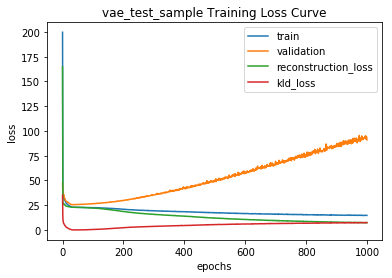

VAE(
  (fc1): Linear(in_features=4998, out_features=50, bias=True)
  (fc21): Linear(in_features=50, out_features=20, bias=True)
  (fc22): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=4998, bias=True)
)


In [288]:
vae.plot_model("./logs/vae/{0}_model_architecture".format(vae.name))
vae.plot_history("./logs/vae/{0}_training_history".format(vae.name))
vae.show_model(None)
load_vae = GenerativeVAE(args)
load_vae.load_model("./models/{0}/checkpoint_1000.pt".format(vae.name))
for parameter_name, load_weights in load_vae.model.state_dict().items():
    vae_weights = vae.model.state_dict()[parameter_name]
    assert(torch.all(torch.eq(load_weights, vae_weights)).item())

for (x, _) in test_loader:         
    x = x.to(load_vae.device)
    z, z_mean, z_var = load_vae.encoder(x, reparameterize=True)
    z_mean_2, z_var_2 = vae.encoder(x)
    assert(torch.all(torch.eq(z_mean, z_mean_2)).item())
    assert(torch.all(torch.eq(z_var, z_var_2)).item())
    recon_x = load_vae.decoder(z)
    recon_x_2 = vae.decoder(z)
    loss_1 = vae.elbo_loss(recon_x, x, z_mean, z_var).item()
    loss_2 = vae.elbo_loss(recon_x_2, x, z_mean, z_var).item()
    np.testing.assert_equal(loss_1, loss_2)

In [228]:
if logger:
    logger.close()

In [ ]:
model = VAE(784, 400, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'logs/vae/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
"""
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()
"""
class Args:
    def __init__(self):
        self.batch_size = 128
        self.epochs = 2
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 10
        

args = Args()

args.cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

train(1)

In [33]:
def string_to_index(string, alphabet):
    return np.array([alphabet.index(s) for s in string])

wild_type_index = string_to_index(get_wild_type_amino_acid_sequence(), alphabet = get_all_amino_acids())
wild_type_index_tensor = torch.from_numpy(wild_type_index)

In [52]:
normalized_prob = np.random.randint(0, 21, 21)
normalized_prob = normalized_prob / normalized_prob.sum()
x = torch.tensor([[0] * 15 + [1] + [0] * 5, normalized_prob])
wild_type_probs = []
for probs, index in zip(x, wild_type_index):
    wild_type_probs.append(probs[index])

sums = x.sum(dim = 1)
print(x, sums)
sums = sums - torch.tensor(wild_type_probs)
print(sums)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0822, 0.0137, 0.0320, 0.0091, 0.0639, 0.0776, 0.0046, 0.0502, 0.0776,
         0.0913, 0.0594, 0.0137, 0.0000, 0.0868, 0.0228, 0.0320, 0.0411, 0.0548,
         0.0411, 0.0776, 0.0685]], dtype=torch.float64) tensor([1.0000, 1.0000], dtype=torch.float64)
tensor([1.0000, 0.9087], dtype=torch.float64)


In [55]:
loss = nn.CrossEntropyLoss()
input = torch.randn(2, 3, 4, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

In [60]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 4, 2])

In [66]:
x = torch.randn(3, 5)
print(x)
x.argmax(dim = 1)

tensor([[-1.4653, -1.0134,  0.0671, -2.0208, -0.0811],
        [-0.5681,  1.4572,  1.2459, -0.1435,  0.7575],
        [ 0.2731, -2.1939,  0.1123, -0.6824,  0.4075]])


tensor([2, 1, 4])

In [63]:
length = 10
wild_type = get_wild_type_amino_acid_sequence()
one_hot = one_hot_encode([wild_type[0:length], wild_type[0:length]], get_all_amino_acids())
for i in range(one_hot.shape[0]): 
    for j in range(one_hot.shape[1]): 
        if not one_hot[i, j]:
            one_hot[i, j] = eps
        else:
            one_hot[i, j] = 1
            
one_hot_tensor = torch.from_numpy(one_hot)
print(one_hot_tensor.shape)
labels = one_hot_tensor.view(2, length, len(get_all_amino_acids())).argmax(dim = 2).float()
print(labels.shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids()))[0][0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1).shape)
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, :, 0])
print(one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)[0, 16])
x = one_hot_tensor.view(2, length, len(get_all_amino_acids())).permute(0, 2, 1)
z = nn.CrossEntropyLoss(reduction='sum')(x, labels).item()
print(z)

torch.Size([2, 210])
torch.Size([2, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
torch.Size([2, 21, 10])
tensor([-1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08,  1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08], dtype=torch.float64)
tensor([ 1.0000e+00, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08,
        -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08, -1.0000e+08],
       dtype=torch.float64)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [46]:
eps = -1e8
x = torch.tensor(np.array([[1, eps, eps], [eps, 1, eps]])).float()
labels = torch.tensor(np.array([0, 1]))
print(torch.all(torch.eq(x.argmax(1), labels)).item() == 1)
F.cross_entropy(x, labels, reduction='sum')

True


tensor(0.)

In [32]:
[x if x else eps for x in one_hot[0]]

(2, 63)

In [175]:
x = torch.randn(3, 3, 5)


tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [179]:
z = F.log_softmax(x, dim=2)
z

tensor([[[-2.1489, -1.4456, -3.2613, -3.3038, -0.5574],
         [-2.2018, -1.3564, -1.8980, -0.8716, -2.7541],
         [-1.0349, -1.3823, -1.8581, -3.3522, -1.5958]],

        [[-1.8522, -3.5563, -0.7642, -3.0691, -1.1961],
         [-2.2367, -2.4859, -0.9454, -2.5285, -1.0740],
         [-1.3448, -2.4309, -1.0460, -2.8123, -1.4270]],

        [[-3.8434, -0.5309, -2.8926, -2.6222, -1.3378],
         [-2.8145, -2.0604, -0.9137, -1.0996, -2.5432],
         [-0.4621, -2.3404, -2.8733, -2.2319, -2.2081]]])

In [186]:
x = torch.zeros(3, 3, 5)
x[:, :, 4] = 1
x

tensor([[[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]]])

In [188]:
-(z * x).sum()

tensor(14.6936)